In [33]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

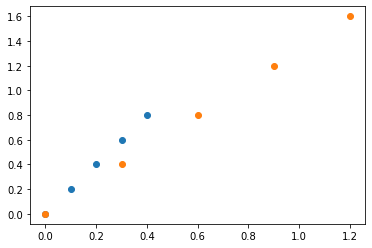

[[0.  0. ]
 [0.1 0.2]
 [0.2 0.4]
 [0.3 0.6]
 [0.4 0.8]]
[[0.  0. ]
 [0.3 0.4]
 [0.6 0.8]
 [0.9 1.2]
 [1.2 1.6]]


In [34]:
t = np.arange(0, 5)

x1 = np.array([0, 0]) + np.c_[0.1*t, 0.2*t]
x2 = np.array([0, 0]) + np.c_[0.3*t, 0.4*t]

plt.scatter(x1[:, 0], x1[:, 1])
plt.scatter(x2[:, 0], x2[:, 1])

plt.show()

print(x1)
print(x2)

[[array([0., 0.])], [array([0.3, 0.4]), [2, 3]], [array([0.6, 0.8])], [array([0.9, 1.2]), array([0.3, 0.6])], [array([0.4, 0.8]), array([1.2, 1.6])]]


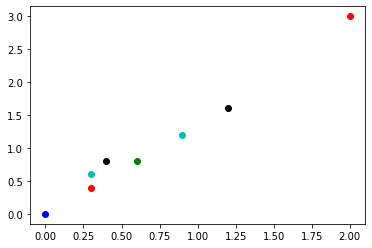

In [35]:
Ds = [
    [x1[0]], # points cannot be replicated
    # [x2[1], x1[1], [2, 3]],
    [x2[1], [2, 3]],
    # [x1[2], x2[2]],
    [x2[2]],
    [x2[3], x1[3]],
    [x1[4], x2[4]],
]

print(Ds)

colors = ['b', 'r', 'g', 'c', 'k']

for i in range(0, 5):
    D = np.array(Ds[i])
    plt.scatter(D[:, 0], D[:, 1], c=colors[i])

plt.show()

In [36]:
def support_estimate(Ds, nns, sup_i, est_i, tol=0.05, radius=100):
    supports = []
    
    sup_i0, sup_i1 = sup_i # Support indexes
    
    # Maybe buggy
    # neigh_dist, _ = nns[sup_i1].radius_neighbors(Ds[sup_i0], radius=radius)
    # idxs_sorted = [np.argsort(neigh_d) for neigh_d in neigh_dist]
    
    # Should be correct
    neigh_dist, _ = nns[sup_i1].radius_neighbors(Ds[sup_i0], radius=np.inf)
    idxs_sorted = [np.argsort(neigh_d) for neigh_d in neigh_dist]
    
    for j_sup0, p_sup0 in enumerate(Ds[sup_i0]):        
        for j_sup1 in idxs_sorted[j_sup0]:    
            support = -1*np.ones(5, dtype='int')
            
            support[sup_i0] = j_sup0
            support[sup_i1] = j_sup1            

            # Use support pair to fit a linear model
            p_sup0 = Ds[sup_i0][j_sup0]
            p_sup1 = Ds[sup_i1][j_sup1]
            
            if np.linalg.norm(p_sup0 - p_sup1) > radius:
                 continue
                
            v = np.array([p_sup0, p_sup1])
            t = np.array([[sup_i0], [sup_i1]])

            lr = LinearRegression().fit(t, v)

            # Use this pair to estimate subsequent frames
            t_est = np.array(est_i).reshape(-1, 1)
            est = lr.predict(t_est)
            
            # Check if estimates match points in subsequent frames
            for j, e in enumerate(est):
                dist, idxs = nns[est_i[j]].radius_neighbors([e], radius=tol)
                
                if dist[0].size > 0:                    
                    closest_idx = idxs[0][np.argmin(dist[0])]
                    # Add closest match to support or negative index if no match is found
                    support[est_i[j]] = closest_idx
                else:
                    support[est_i[j]] = -1 

            # Add to support only if at least 3 matches are found
            count = np.sum(support >= 0)
            
            if np.sum(support >= 0) >= 3:               
                supports.append( support )
        
    return supports

In [37]:
# Test support estimate
nns = [NearestNeighbors(metric='euclidean').fit(Ds[i]) for i in range(0, 5)]

# Forward pass
supports = support_estimate(Ds, nns, [0, 1], [2, 3, 4])
supports += support_estimate(Ds, nns, [1, 2], [3, 4])
supports += support_estimate(Ds, nns, [2, 3], [4])
# Backward pass
supports += support_estimate(Ds, nns, [4, 3], [2, 1, 0])
supports += support_estimate(Ds, nns, [3, 2], [1, 0])
supports += support_estimate(Ds, nns, [2, 1], [0])

supports = np.array(supports)

print(supports)

for support in supports:
    row = []
    
    for i, s in enumerate(support):        
        if s == -1:
            row.append(np.array([]))
        else:
            row.append(Ds[i][s])
        
    print(row)

[[ 0  0  0  0  1]
 [-1  0  0  0  1]
 [-1 -1  0  0  1]
 [ 0 -1 -1  1  0]
 [ 0  0  0  0  1]
 [ 0  0  0  0 -1]
 [ 0  0  0 -1 -1]]
[array([0., 0.]), array([0.3, 0.4]), array([0.6, 0.8]), array([0.9, 1.2]), array([1.2, 1.6])]
[array([], dtype=float64), array([0.3, 0.4]), array([0.6, 0.8]), array([0.9, 1.2]), array([1.2, 1.6])]
[array([], dtype=float64), array([], dtype=float64), array([0.6, 0.8]), array([0.9, 1.2]), array([1.2, 1.6])]
[array([0., 0.]), array([], dtype=float64), array([], dtype=float64), array([0.3, 0.6]), array([0.4, 0.8])]
[array([0., 0.]), array([0.3, 0.4]), array([0.6, 0.8]), array([0.9, 1.2]), array([1.2, 1.6])]
[array([0., 0.]), array([0.3, 0.4]), array([0.6, 0.8]), array([0.9, 1.2]), array([], dtype=float64)]
[array([0., 0.]), array([0.3, 0.4]), array([0.6, 0.8]), array([], dtype=float64), array([], dtype=float64)]


In [38]:
# Remove subsequences

def remove_subsequences(supports):

    output = supports.copy()

    for i, support in enumerate(supports):
        a = support
        a[a == -1]
        query = a[a != -1]

        Q = supports[:, (a != -1)]

        row = np.max(supports[np.all(query == Q, axis=1)], axis=0)
        
        output[i] = row
        
    return np.unique(output, axis=0)

In [39]:
# Test remove subsequences

supports = [
    [ 3,  1,  2,  0, -1],
    [ 4,  2,  4,  1, -1],
    [ 7,  5, 15, 10,  1],
    [-1,  1,  2,  0, -1],
    [-1,  2,  4,  1, -1],
    [-1,  5, 15, 10,  1],
    [-1, -1, 15, 10,  1],
    [ 7,  5, 15, 10,  1],
    [ 3,  1,  2,  0, -1],
    [ 4,  2,  4,  1, -1],
    [ 7,  5, 15, 10, -1],
    [ 3,  1,  2, -1, -1],
    [ 4,  2,  4, -1, -1],
    [ 7,  5, 15, -1, -1],
    [ 6,  4, 16, -1, -1]
]

supports = np.array(supports)

print(supports)

print('output')
print(remove_subsequences(supports))

[[ 3  1  2  0 -1]
 [ 4  2  4  1 -1]
 [ 7  5 15 10  1]
 [-1  1  2  0 -1]
 [-1  2  4  1 -1]
 [-1  5 15 10  1]
 [-1 -1 15 10  1]
 [ 7  5 15 10  1]
 [ 3  1  2  0 -1]
 [ 4  2  4  1 -1]
 [ 7  5 15 10 -1]
 [ 3  1  2 -1 -1]
 [ 4  2  4 -1 -1]
 [ 7  5 15 -1 -1]
 [ 6  4 16 -1 -1]]
output
[[ 3  1  2  0 -1]
 [ 4  2  4  1 -1]
 [ 6  4 16 -1 -1]
 [ 7  5 15 10  1]]


In [40]:
def find_support(Ds, radius=100, tol=5):    
    nns = [NearestNeighbors(metric='euclidean').fit(Ds[i]) for i in range(0, 5)]
        
    # Forward pass    
    supports = support_estimate(Ds, nns, [0, 1], [2, 3, 4], radius=radius, tol=tol)
    supports += support_estimate(Ds, nns, [1, 2], [3, 4], radius=radius, tol=tol)
    supports += support_estimate(Ds, nns, [2, 3], [4], radius=radius, tol=tol)
    # Backward pass
    supports += support_estimate(Ds, nns, [4, 3], [2, 1, 0], radius=radius, tol=tol)
    supports += support_estimate(Ds, nns, [3, 2], [1, 0], radius=radius, tol=tol)
    supports += support_estimate(Ds, nns, [2, 1], [0], radius=radius, tol=tol)

    supports = np.array(supports)
    
    return remove_subsequences(supports)

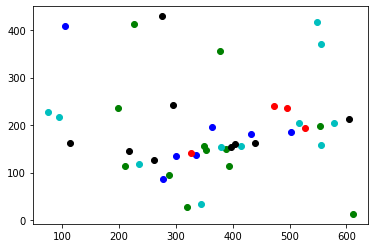

[[-1 -1  3  1  0]
 [ 1  0  5  2  3]
 [ 2 -1  6  3  5]
 [ 4  1  8  6  6]]
coords per frame
0 [array([301, 134]), array([336, 137]), array([502, 186])]
1 [array([327, 141]), array([528, 193])]
2 [array([210, 113]), array([353, 147]), array([388, 150]), array([553, 199])]
3 [array([236, 119]), array([379, 153]), array([414, 156]), array([579, 205])]
4 [array([262, 126]), array([405, 160]), array([440, 162]), array([605, 212])]
Coords per object
[(2, array([210, 113])), (3, array([236, 119])), (4, array([262, 126]))]
[(0, array([301, 134])), (1, array([327, 141])), (2, array([353, 147])), (3, array([379, 153])), (4, array([405, 160]))]
[(0, array([336, 137])), (2, array([388, 150])), (3, array([414, 156])), (4, array([440, 162]))]
[(0, array([502, 186])), (1, array([528, 193])), (2, array([553, 199])), (3, array([579, 205])), (4, array([605, 212]))]


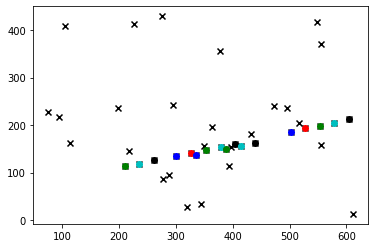

In [41]:
import pickle

Ds1 = pickle.load(open('ds.pkl', 'rb'))

for i in range(0, 5):
    D = np.array(Ds1[i])
    plt.scatter(D[:, 0], D[:, 1], c=colors[i])

plt.show()

# Find support
S = find_support(Ds1, radius=50, tol=5)
print(S)

coords_per_frame = [[Ds1[i][support[i]] for support in S if support[i] != -1] for i in range(0, 5)]
coords_per_object = [[(i, Ds1[i][support[i]]) for i in range(0, 5) if support[i] != -1] for support in S]

trajectories = [[np.append(i, Ds1[i][support[i]]) for i in range(0, 5) if support[i] != -1] for support in S]

print('coords per frame')
for i, coords in enumerate(coords_per_frame):
    print(i, coords)

print('Coords per object')
for obj in coords_per_object:
    print(obj)
    
for frameid in range(0, 5):
    plt.scatter(np.array(Ds1[frameid])[:, 0], np.array(Ds1[frameid])[:, 1], c='k', marker='x')
    
for obj in coords_per_object:
    for frameid, coords in obj:        
        plt.scatter(coords[0], coords[1], color=colors[frameid])
    
plt.show()
    

In [42]:
print( trajectories )

[[array([  2, 210, 113]), array([  3, 236, 119]), array([  4, 262, 126])], [array([  0, 301, 134]), array([  1, 327, 141]), array([  2, 353, 147]), array([  3, 379, 153]), array([  4, 405, 160])], [array([  0, 336, 137]), array([  2, 388, 150]), array([  3, 414, 156]), array([  4, 440, 162])], [array([  0, 502, 186]), array([  1, 528, 193]), array([  2, 553, 199]), array([  3, 579, 205]), array([  4, 605, 212])]]


In [43]:
# Interpolate missing values

def interpolate(trajectory):
    trajectory = np.array(trajectory)

    lr = LinearRegression().fit(trajectory[:, 0].reshape(-1, 1), trajectory[:, [1, 2]])
    
    coords = []

    for frameid in range(0, 5):
        c = trajectory[trajectory[:, 0] == frameid][:, [1, 2]]
        
        if len(c) > 0:
            coords.append(c[0])
        else:
            pred = lr.predict([[frameid]])
            coords.append(pred[0])            
        
    return np.array(coords)

In [44]:
import pickle

Ts = pickle.load(open('ts.pkl', 'rb'))

from skimage import transform

# Interpolate coordinates
interpolated = [interpolate(trajectory) for trajectory in trajectories]

# Convert to frame-first
object_coords = []

for frameid in range(0, 5):
    coords = np.stack([c[frameid] for c in interpolated])
    object_coords.append(coords)

# Transform to original reference frame
for frameid, coords in enumerate(object_coords):
    object_coords[frameid] = transform.matrix_transform(coords, np.linalg.inv(Ts[frameid]))

object_coords = [o.tolist() for o in object_coords]

print(object_coords)

[[[265.75000000000006, 60.46333333333334], [408.75, 94.63], [443.75, 97.63], [609.75, 146.63]], [[237.87500000000006, 86.64833333333334], [380.875, 121.315], [415.875, 123.74357142857144], [581.875, 173.315]], [[210.0, 113.0], [353.0, 147.0], [388.0, 150.0], [553.0, 199.0]], [[182.125, 138.685], [325.125, 172.685], [360.125, 175.685], [525.125, 224.685]], [[154.25, 165.37], [297.25, 199.37], [332.25, 201.37], [497.25, 251.37]]]


In [45]:
from skimage import transform

seqid = 1

predictions = []

for frameid, coords in enumerate(object_coords):    
    prediction = {'sequence_id': seqid, 'frame': frameid, 'num_objects': len(coords), 'object_coords': coords}
    predictions.append(prediction)
    
print(predictions)

[{'sequence_id': 1, 'frame': 0, 'num_objects': 4, 'object_coords': [[265.75000000000006, 60.46333333333334], [408.75, 94.63], [443.75, 97.63], [609.75, 146.63]]}, {'sequence_id': 1, 'frame': 1, 'num_objects': 4, 'object_coords': [[237.87500000000006, 86.64833333333334], [380.875, 121.315], [415.875, 123.74357142857144], [581.875, 173.315]]}, {'sequence_id': 1, 'frame': 2, 'num_objects': 4, 'object_coords': [[210.0, 113.0], [353.0, 147.0], [388.0, 150.0], [553.0, 199.0]]}, {'sequence_id': 1, 'frame': 3, 'num_objects': 4, 'object_coords': [[182.125, 138.685], [325.125, 172.685], [360.125, 175.685], [525.125, 224.685]]}, {'sequence_id': 1, 'frame': 4, 'num_objects': 4, 'object_coords': [[154.25, 165.37], [297.25, 199.37], [332.25, 201.37], [497.25, 251.37]]}]
